# Random Forest

### Problem Statement

To build an application to classify the patients to be healthy or suffering from cardiovascular disease based on the given attributes.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [7]:
df = pd.read_csv('cardio_train.csv',sep = ';')
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,988,22469,1,155,69.0,130,80,2,2,0,0,1,0
1,989,14648,1,163,71.0,110,70,1,1,0,0,1,1
2,990,21901,1,165,70.0,120,80,1,1,0,0,1,0
3,991,14549,2,165,85.0,120,80,1,1,1,1,1,0
4,992,23393,1,155,62.0,120,80,1,1,0,0,1,0


In [8]:
df.shape

(69301, 13)

In [9]:
df.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000
mean,50471.480397,19468.786280,1.349519,164.362217,74.203027,128.829584,96.650092,1.366806,1.226447,0.088051,0.053881,0.803986,0.499589
std,28563.100347,2467.261818,0.476821,8.205337,14.383469,154.775805,189.096240,0.680270,0.572246,0.283371,0.225784,0.396982,0.500003
min,988.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25745.000000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50494.000000,19704.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,75150.000000,21326.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
# Observations
#1 - No missing values
#2 - Assuming age in number of days
#3 - outliers in height
#4 - outliers in blood pressure
#5 - outliers in ap_low
#6 = seems cholesterol and glucose are binary.

In [13]:
df.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
69296    False
69297    False
69298    False
69299    False
69300    False
Length: 69301, dtype: bool

In [14]:
dups = df.pivot_table(index = ['age','gender','height','weight','ap_hi','ap_lo','cholesterol','gluc','smoke','alco','active','cardio'], aggfunc ='size')

In [15]:
dups

age    gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  alco  active  cardio
10798  2       175     92.0    100    60     1            1     0      0     1       0         1
10859  1       159     59.0    120    80     1            1     0      0     1       0         1
10878  1       175     59.0    120    80     1            1     0      0     1       0         1
10964  1       160     59.0    110    70     1            1     0      0     1       0         1
14275  1       164     105.0   150    110    3            3     0      0     1       1         1
                                                                                              ..
23687  2       163     55.0    120    80     3            1     1      0     1       1         1
23690  1       165     63.0    150    90     2            1     0      0     1       1         1
23692  2       167     68.0    120    80     2            2     0      0     0       1         1
23701  1       178     75.0    120 

## Remove duplicates

In [16]:
# Drop id and remove duplicates
df.drop('id',axis = 1,inplace = True)
# Duplicates removal
df.drop_duplicates(inplace = True)


In [17]:
df.shape

(69277, 12)

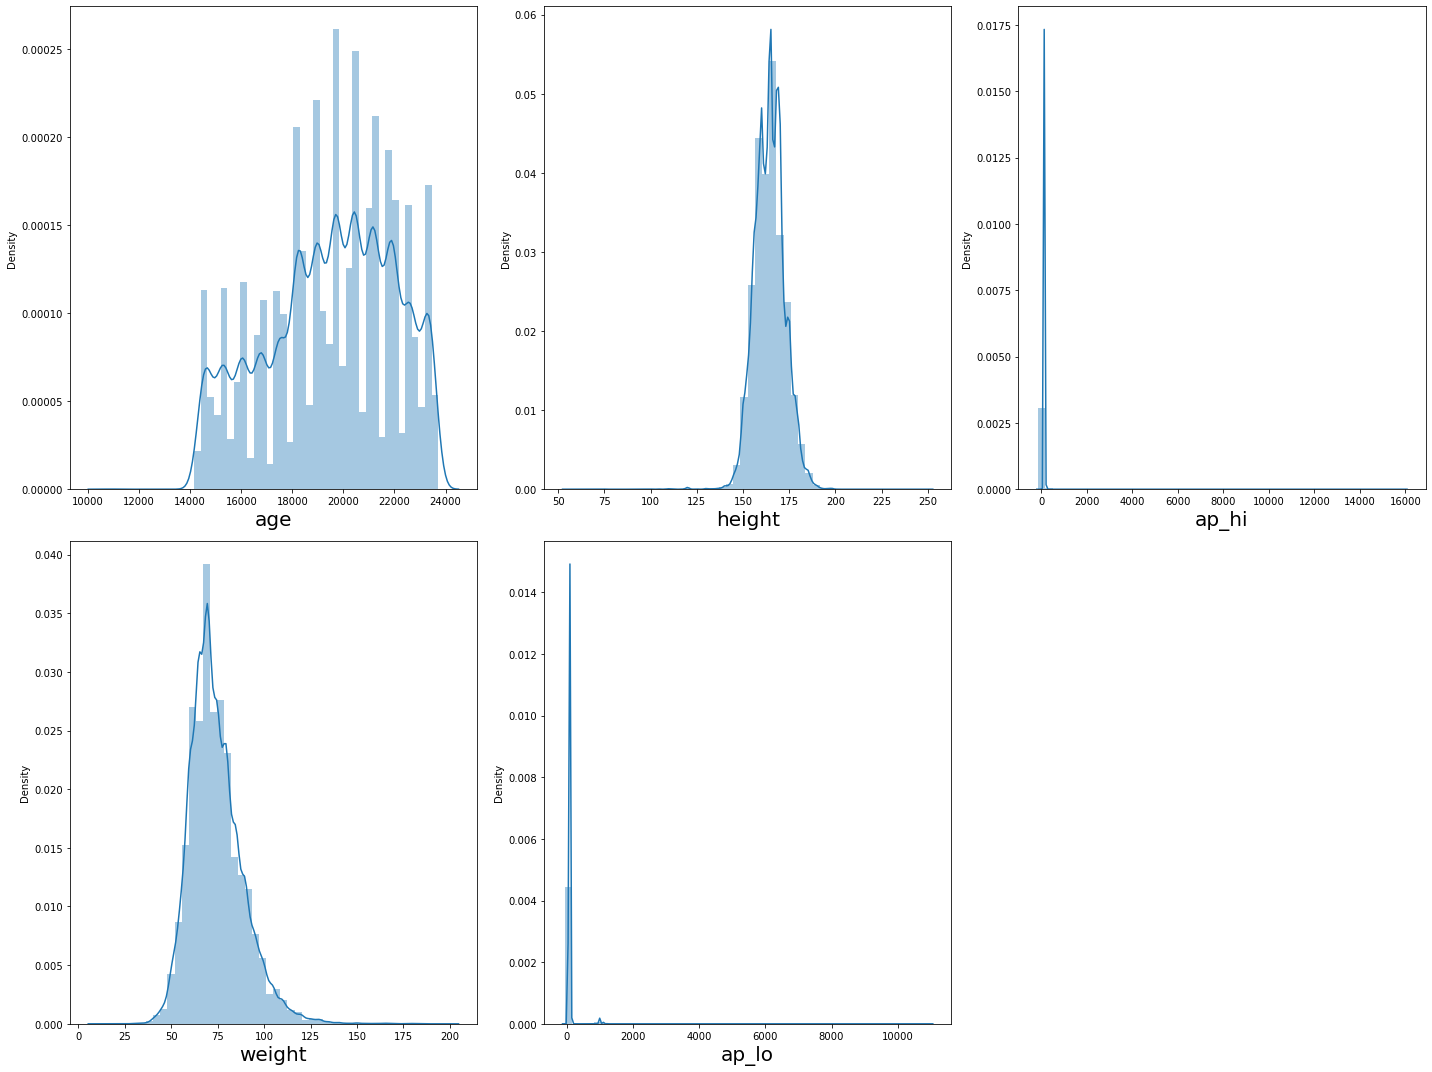

In [18]:
plt.figure(figsize=(20,15))
plotnumber = 1
for column in df[['age','height','ap_hi','weight','ap_lo']]:
    if plotnumber <= 6:
        ax = plt.subplot(2,3,plotnumber)
        sns.distplot(df[column])
        plt.xlabel(column,fontsize = 20)
        plotnumber += 1
        plt.tight_layout()

In [19]:
# with std 3 let's see the stats
# from scipy import stats
# z score = (x-mean)/std
from scipy.stats import zscore
z_score = zscore(df[['age','height','ap_hi','weight','ap_lo']])
abs_z_score = np.abs(z_score) # Apply this formula and get the scaled data.
filtering_entry = (abs_z_score < 3).all(axis = 1)
df = df[filtering_entry]
df.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,67360.000000,67360.000000,67360.000000,67360.000000,67360.000000,67360.000000,67360.000000,67360.000000,67360.000000,67360.000000,67360.000000,67360.000000
mean,19466.779053,1.347268,164.374555,73.566278,126.164430,81.286001,1.362010,1.223575,0.087159,0.053281,0.803949,0.492815
std,2467.040240,0.476105,7.690310,13.195627,17.860035,10.236086,0.677075,0.569505,0.282069,0.224595,0.397011,0.499952
min,14275.000000,1.000000,140.000000,32.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17660.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19702.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21324.000000,2.000000,170.000000,81.000000,140.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,188.000000,117.000000,401.000000,602.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,22469,1,155,69.0,130,80,2,2,0,0,1,0
1,14648,1,163,71.0,110,70,1,1,0,0,1,1
2,21901,1,165,70.0,120,80,1,1,0,0,1,0
3,14549,2,165,85.0,120,80,1,1,1,1,1,0
4,23393,1,155,62.0,120,80,1,1,0,0,1,0


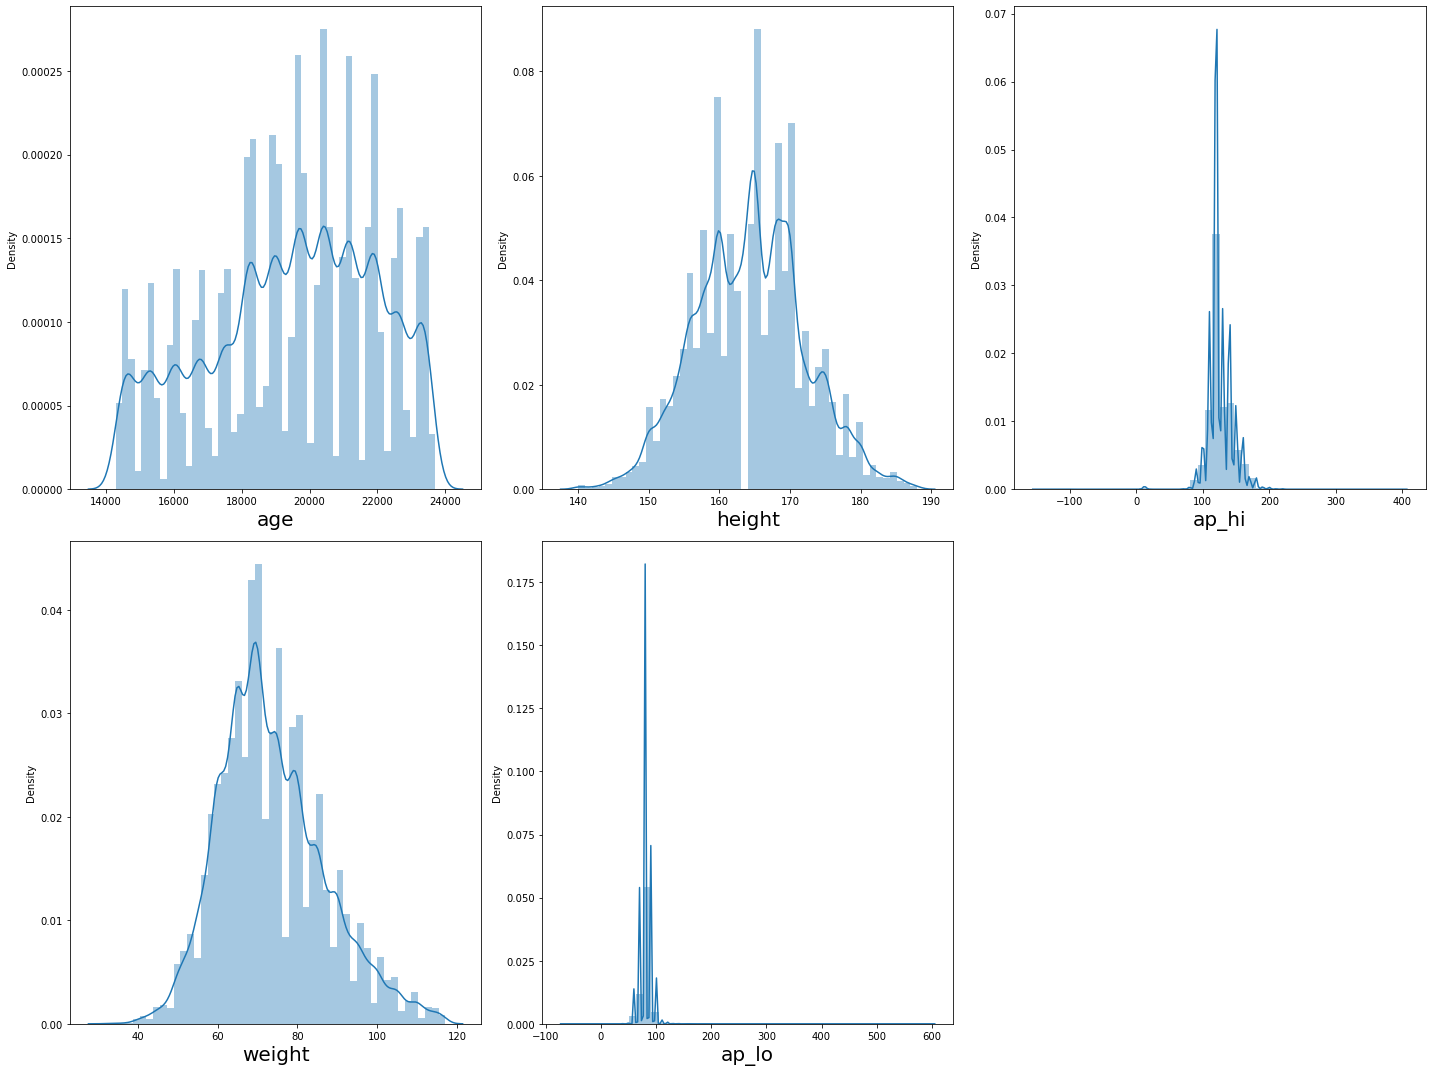

In [21]:
plt.figure(figsize=(20,15))
plotnumber = 1
for column in df[['age','height','ap_hi','weight','ap_lo']]:
    if plotnumber <= 6:
        ax = plt.subplot(2,3,plotnumber)
        sns.distplot(df[column])
        plt.xlabel(column,fontsize = 20)
        plotnumber += 1
        plt.tight_layout()

In [22]:
# cannot make out much from the above plots.Lets build the model.
x = df.drop(columns = ['cardio'],axis = 1)
y = df['cardio']

# Let's Tune parameters using GridSearchCV

In [28]:
# RandomForestClassifier
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.25,random_state = 41)
clf = RandomForestClassifier()
params = {'n_estimators': [13,15],
          'criterion': ['entropy','gini'],
          'max_depth': [10,15],
          'min_samples_split': [10,11],
          'min_samples_leaf': [5,7]}
grid = GridSearchCV(clf,param_grid = params)
grid.fit(x_train,y_train)
print('best_params =',grid.best_params_)
clf = grid.best_estimator_ # reinstating with best params
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
conf_mat = confusion_matrix(y_test,y_pred)
print('\nconf mat =','\n',conf_mat)
print('Accuracy rf normal =',accuracy_score(y_test,y_pred))


best_params = {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 7, 'min_samples_split': 10, 'n_estimators': 15}

conf mat = 
 [[6729 1814]
 [2708 5589]]
Accuracy rf normal = 0.7314726840855107


In [29]:
report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.71      0.79      0.75      8543
           1       0.75      0.67      0.71      8297

    accuracy                           0.73     16840
   macro avg       0.73      0.73      0.73     16840
weighted avg       0.73      0.73      0.73     16840



#### You can improve the preformance by tweaking preprocessing methods

# Let's plot ROC AUC curve to choose the best model

In [32]:
# Plot ROC/AUC for multiple models without hyperparams tuning.
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import plot_roc_curve

In [33]:
lr = LogisticRegression()
kn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()

In [34]:
# Train Test Split
x = df.drop(columns = ['cardio'],axis = 1)
y = df['cardio']

In [39]:
x_train,x_test,y_train,y_test = train_test_split(x,y, test_size = 0.25,random_state = 41)
# training with all classifier
lr.fit(x_train,y_train)
kn.fit(x_train,y_train)
dt.fit(x_train,y_train)
rf.fit(x_train,y_train)
print('All models are trained')

All models are trained


In [41]:
# All models score captured
lr.score(x_test,y_test)
kn.score(x_test,y_test)
dt.score(x_test,y_test)
rf.score(x_test,y_test)
print('All models score captured')

All models score captured


# Let's check Roc Auc Curve for fitted model

#### True Positive Rate(TPR)= out of 100 actual cardio patients how many our model predicted as cardio patient correctly.(Higher the better)

##### False Positive Rate(FPR)= How many people were predicted as cardio patients but in reality they were healthy,(Lower the better)

since it is difficult to evaluate the score based on only TPR and FPR data,then comes AUC 

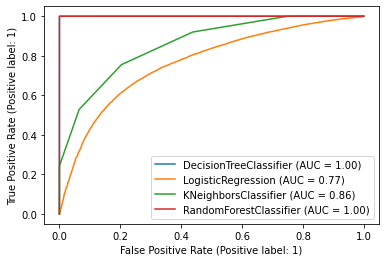

In [42]:
# How well model works on training data
disp = plot_roc_curve(dt,x_train,y_train)
plot_roc_curve(lr,x_train,y_train,ax = disp.ax_)
plot_roc_curve(kn,x_train,y_train,ax = disp.ax_)
plot_roc_curve(rf,x_train,y_train,ax = disp.ax_)
plt.legend(prop={'size':10},loc = 'lower right')
plt.show()

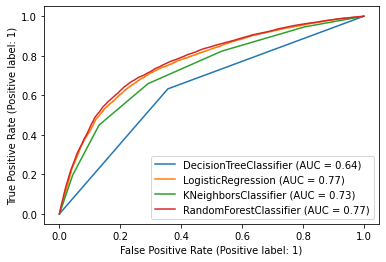

In [43]:
# How our model works on test data
disp = plot_roc_curve(dt,x_test,y_test)
plot_roc_curve(lr,x_test,y_test,ax = disp.ax_)
plot_roc_curve(kn,x_test,y_test,ax = disp.ax_)
plot_roc_curve(rf,x_test,y_test,ax = disp.ax_)
plt.legend(prop={'size':10},loc = 'lower right')
plt.show()